In [1]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts.models import (
    NaiveSeasonal, MovingAverage, 
    NBEATSModel, KalmanFilter, GaussianProcessFilter, 
    ARIMA, RegressionModel)

In [2]:
import darts.anomaly_detection.score as S
import darts.anomaly_detection.detector as D
import darts.anomaly_detection.anomaly_model as AM

In [3]:
series = AirPassengersDataset().load()
series_train, series_test = series.split_before(pd.Timestamp("19580101"))

# create fake anomalies TS 
np_anomalies = np.random.choice(a = [0,1], size = len(series_test), p = [0.7, 0.3])
anomalies = TimeSeries.from_times_and_values(series_test._time_index, np_anomalies)

# Anomaly Model (Trained model + scorer)

In [4]:
# possible models
# filter: Kallman/MovingAverage
# model: NaiveSeasonal/ARIMA

# possible scorers 5
# trainable: KmeansAnomaly/LocalOutlierFactorAnomaly
# not trainable: L1/L2/difference

# forecasting model trainable, scorer trainable 
AS_model1 = AM.ForecastingAnomalyModel(
    model = NaiveSeasonal(K=12),
    scorer = S.KmeansAnomaly(k=4)
)
AS_model1.fit(series_train)
anomaly_score1 = AS_model1.score(series_test)

# forecasting model trainable, scorer not trainable 
AS_model2 = AM.ForecastingAnomalyModel(
    model = NaiveSeasonal(K=12),
    scorer = S.L1()
)
AS_model2.fit(series_train)
anomaly_score2 = AS_model2.score(series_test)

# forecasting model trainable, scorer not trainable 
AS_model3 = AM.ForecastingAnomalyModel(
    model= RegressionModel(lags=4),
    scorer= S.L2()
)
AS_model3.fit(series_train)
anomaly_score3 = AS_model3.score(series_test)

# filtering model trainable, scorer not trainable 
AS_model4 = AM.FilteringAnomalyModel(
    filter= KalmanFilter(),
    scorer= S.difference()
)
AS_model4.fit(series_train)
anomaly_score4 = AS_model4.score(series_test)

# filtering model trainable, scorer  trainable 
AS_model5 = AM.FilteringAnomalyModel(
    filter= KalmanFilter(),
    scorer= S.KmeansAnomaly(k=4)
)
AS_model5.fit(series_train)
anomaly_score5 = AS_model5.score(series_test)

# filtering model not trainable, scorer trainable 
AS_model6 = AM.FilteringAnomalyModel(
    filter= MovingAverage(window=10),
    scorer= S.KmeansAnomaly(k=4)
)
AS_model6.fit(series_train)
anomaly_score6 = AS_model6.score(series_test)

# filtering model not trainable, scorer not trainable 
AS_model7 = AM.FilteringAnomalyModel(
    filter= MovingAverage(window=10),
    scorer= S.L2()
)
AS_model7.fit(series_train)
anomaly_score7 = AS_model7.score(series_test)

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

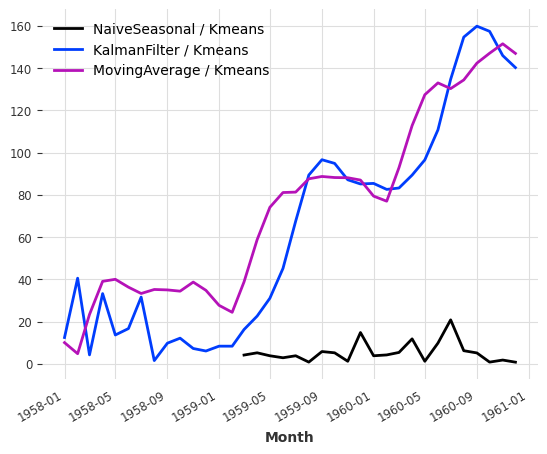

In [5]:
#series_test.plot(label="true values")
anomaly_score1.plot(label="NaiveSeasonal / Kmeans")
#anomaly_score2.plot(label="NaiveSeasonal / L1")
#anomaly_score3.plot(label="RegressionModel / L2")
#anomaly_score4.plot(label="KalmanFilter / diff")
anomaly_score5.plot(label="KalmanFilter / Kmeans")
anomaly_score6.plot(label="MovingAverage / Kmeans")
#anomaly_score7.plot(label="MovingAverage / L2")

plt.show()

# Scorer 

In [6]:
modified_series = MovingAverage(window=10).filter(series_test)
dif = S.L1().compute(series_test, modified_series)

# Detector 

In [7]:
model_thresh = D.ThresholdAD(10,400)
anomalies_thresh = model_thresh.detect(series_test)

print("Model ThresholdAD")
print("f1 score :", model_thresh.score(series_test, anomalies, scoring="f1"))
print("recall :", model_thresh.score(series_test, anomalies, scoring="recall"))

model_quantile = D.QuantileAD(0.05,0.95)
anomalies_quantile = model_quantile.fit_detect(series_train)

print("Model QuantileAD")
print("f1 score :", model_quantile.score(series_test, anomalies, scoring="f1"))
print("recall :", model_quantile.score(series_test, anomalies, scoring="recall"))

Model ThresholdAD
f1 score : 0.39999999999999997
recall : 0.5384615384615384
Model QuantileAD
f1 score : 0.4444444444444444
recall : 0.6153846153846154
